<font size = "+3"><strong>Heart Disease</strong></font>

<font size = "+1"><strong>Report if chest pain is an indicator of a heart disease</strong></font>

<font face = "calibri">
<p>There are several types of diseases, and one of them is the heart disease. Literally, the heart disease is any disease that causes the heart not to function properly. Several factors which include lifestyle changes, abuse of illicit drug and stress can cause heart failure. <p>Note that heart diseases are of different types and each has its own symptoms. One of the symptoms of a heart disease is the chest pain. <p>In this project, we'll try to get a sense if chest pain is an indicator or heart disease using a Logistic Regression model

# Prepare Data

## Import

**Task 1:** Import all necessary libraries

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

**Task 2:** Create a wrangle function to clean the dataset

In [42]:
#Create a wrangle function
def wrangle(filepath):
    df = pd.read_fwf(filepath)
    
    #Change the column names to match the data dictionary
    df[["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]] = df["63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0"].str.split(",", expand = True)

    df.drop(columns = "63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0", inplace = True)

    # Typecasting
    df = df.select_dtypes("object").astype(float)
    df[["age", "sex", "cp","fbs","restecg","exang","slope","ca","thal","num"]] = df[["age","sex", "cp","fbs","restecg","exang","slope","ca","thal","num"]].astype(int)

    #Perform binary classification:- 0 = No heart disease and >0 = Heart disease
    df["disease"] = (df["num"] > 0).astype(int)

    #Replace categorical values with actual values
    df["sex"].replace({1:"Male", 0 : "Female"}, inplace = True)
    df["cp"].replace({1:"Typical Angina", 2 : "Atypical angina", 3 : "Non-anginal pain", 4 : "Asymptomatic"}, inplace = True)
    df["restecg"].replace({0:"Normal", 1 : "Abnormal", 2 : "Abnormal"}, inplace = True)
    df["exang"].replace({1:"Yes", 0 : "No"}, inplace = True)
    df["fbs"].replace({1:"True", 0 : "False"}, inplace = True)
    df["slope"].replace({1: "upsloping", 2: "Flat", 3: "Down sloping"}, inplace = True)
    df["thal"].replace({3: 'Normal', 6: 'Fixed defect' , 7: 'Reversible defect'}, inplace = True)    
    df = df[(df.thal != 0)]

    df.drop(columns = "num", inplace = True)

    return df
    
df = wrangle("processed.cleveland.data")
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,67,Male,Asymptomatic,160.0,286.0,False,Abnormal,108.0,Yes,1.5,Flat,3,Normal,1
1,67,Male,Asymptomatic,120.0,229.0,False,Abnormal,129.0,Yes,2.6,Flat,2,Reversible defect,1
2,37,Male,Non-anginal pain,130.0,250.0,False,Normal,187.0,No,3.5,Down sloping,0,Normal,0
3,41,Female,Atypical angina,130.0,204.0,False,Abnormal,172.0,No,1.4,upsloping,0,Normal,0
4,56,Male,Atypical angina,120.0,236.0,False,Normal,178.0,No,0.8,upsloping,0,Normal,0


**Comment:** The binary classification of the heart disease is 0 is classified as 'no heart disease' while numbers greater than 0 are classified as heart disease

**Task 3:** Inspect dataframe

In [43]:
print("Shape of dataframe: ", df.shape)
print("Dataframe information\n")
df.info()

Shape of dataframe:  (300, 14)
Dataframe information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       300 non-null    int32  
 1   sex       300 non-null    object 
 2   cp        300 non-null    object 
 3   trestbps  300 non-null    float64
 4   chol      300 non-null    float64
 5   fbs       300 non-null    object 
 6   restecg   300 non-null    object 
 7   thalach   300 non-null    float64
 8   exang     300 non-null    object 
 9   oldpeak   300 non-null    float64
 10  slope     300 non-null    object 
 11  ca        300 non-null    int32  
 12  thal      300 non-null    object 
 13  disease   300 non-null    int32  
dtypes: float64(4), int32(3), object(7)
memory usage: 31.6+ KB


## Explore

**Task 4.1:** Check the proportion of people with heart disease and people without

In [44]:
major, minor = df["disease"].value_counts(normalize = True)
print("Proportion without heart disease: ", major)
print("Proportion with heart disease: ", minor)

Proportion without heart disease:  0.54
Proportion with heart disease:  0.46


**Task 4.2:** Visualize the proportion in (1)

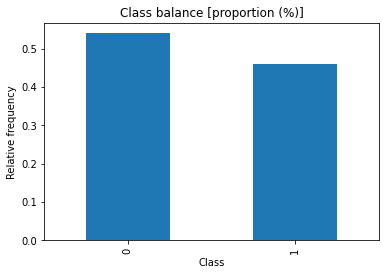

In [45]:
df["disease"].value_counts(normalize = True).plot(kind = "bar")
plt.xlabel("Class")
plt.ylabel("Relative frequency")
plt.title("Class balance [proportion (%)]");

**Task 5:** Plot a correlation heatmap of the numerical features in the datafram to check if the data frame has multicollinearity issues

In [46]:
corr = df.select_dtypes("number").drop(columns = "disease").corr()
corr

,age,trestbps,chol,thalach,oldpeak,ca
age,1.000000,0.283051,0.209471,-0.396613,0.200888,0.368091
trestbps,0.283051,1.000000,0.130186,-0.046479,0.186623,0.098686
chol,0.209471,0.130186,1.000000,-0.005679,0.045902,0.120258
thalach,-0.396613,-0.046479,-0.005679,1.000000,-0.350123,-0.270332
oldpeak,0.200888,0.186623,0.045902,-0.350123,1.000000,0.303199
ca,0.368091,0.098686,0.120258,-0.270332,0.303199,1.000000


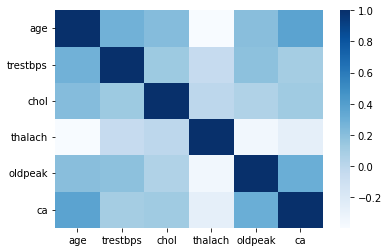

In [47]:
sns.heatmap(corr, cmap = "Blues");

***Comment:*** There is no highly correlated features in the dataframe

**Task 6:** Create a boxplot to display the distributions of the `"age"` column for both groups in the `"disease"` column.

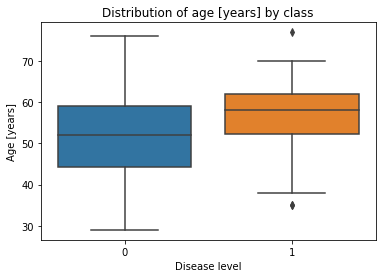

In [48]:
sns.boxplot(data = df, x = "disease", y = "age")
plt.xlabel("Disease level")
plt.ylabel("Age [years]")
plt.title("Distribution of age [years] by class");

***Comment:*** The boxplot shows that 50% of people that do not have heart disease are between 45 and 60 years old, while 50% of people that have heart disease are between 52 and 60 years old

**Task 7.1:** Create a pivot table to check if any of the gender `"male"` or `"female"` likely to suffer a heart disease than the other

In [49]:
sex_pivot = pd.pivot_table(
    df, "disease", "sex", aggfunc = np.mean
).sort_values(by = "disease", ascending = False)
sex_pivot

,disease
sex,
Male,0.553922
Female,0.260417


**Task 7.2:** Visualize the pivot table in (7.1)

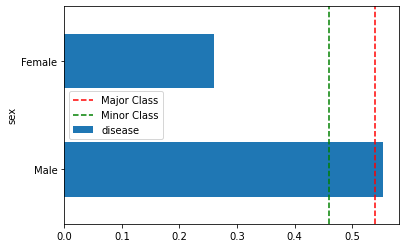

In [50]:
sex_pivot.plot(kind = "barh")
plt.axvline(major, color = "red", linestyle = "--", label = "Major Class")
plt.axvline(minor, color = "green", linestyle = "--", label = "Minor Class")
plt.legend();

***Comment:*** The bar chart shows that the male gender is more likely to have a heart disease

**Task 8.1:** Create a pivot table to check the distribution of the symptoms

In [51]:
cp_pivot = pd.pivot_table(
    df, "disease", "cp", aggfunc = np.mean
).sort_values("disease", ascending = False)
cp_pivot

,disease
cp,
Asymptomatic,0.727273
Typical Angina,0.318182
Non-anginal pain,0.211765
Atypical angina,0.180000


**Task 8.2:** Visualize the pivot table in (8.1)

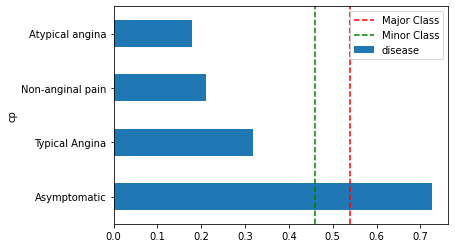

In [52]:
cp_pivot.plot(kind = "barh")
plt.axvline(major, color = "red", linestyle = "--", label = "Major Class")
plt.axvline(minor, color = "green", linestyle = "--", label = "Minor Class")
plt.legend();

***Comment:*** The bar chart shows that people that are asymptomatic are more likely to suffer heart disease (because they do not show any symptom)

## Split

**Task 9:** Create the feature matrix `X` and target vector `y`. The target in this case is `"disease"`. 

In [53]:
target = 'disease'
y = df[target]
X = df.drop(columns = target)

**Task 10:** Create a train_test_split to split the trainig and test data

In [54]:
# Here, the test data is 20% of the whole data set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 50
)

# Build Model

## Baseline

**Task 11:** Calculate the baseline accuracy score of this model

In [55]:
acc_score = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy score: ", round(acc_score, 2))

Baseline Accuracy score:  0.54


## Iterate

**Task 12:** Instantiate and train the model

In [56]:
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    LogisticRegression(max_iter = 1500)
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sex', 'cp', 'fbs', 'restecg', 'exang',
                                     'slope', 'thal'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1500))])

## Evaluate

**Task 13:** Calculate the training accuracy score of this model

In [57]:
train_acc = model.score(X_train, y_train)
print("Training Accuracy score: ", round(train_acc, 2))

Training Accuracy score:  0.87


**Task 14:** Calculate the test accuracy score of this model

In [58]:
test_acc = model.score(X_test, y_test)
print("Test Accuracy score: ", round(test_acc, 2))

Test Accuracy score:  0.91


# Communicate

**Task 15:** Generate an array of predictions of the model

In [59]:
model.predict_proba(X_train)[:,-1][:5]

array([0.04521897, 0.99051408, 0.0153383 , 0.03459673, 0.03249014])

**Task 16:** Calculate the feature importance of the model

In [60]:
feature_name = model.named_steps["onehotencoder"].get_feature_names()
importance = model.named_steps["logisticregression"].coef_[0]

**Task 17:** Create a series to show the level of importance of the features in this model

In [61]:
odd_ratio = pd.Series(
    np.exp(importance), index = feature_name
).sort_values(ascending=True)
odd_ratio.tail(10)

cp_Atypical angina        1.039729
fbs_False                 1.141676
exang_Yes                 1.193332
restecg_Abnormal          1.225683
sex_Male                  1.412443
oldpeak                   1.483613
slope_Flat                1.666875
thal_Reversible defect    1.985424
cp_Asymptomatic           2.938269
ca                        3.221345
dtype: float64

**Task 18:**  Create a horizontal bar chart with the five largest coefficients from the series above

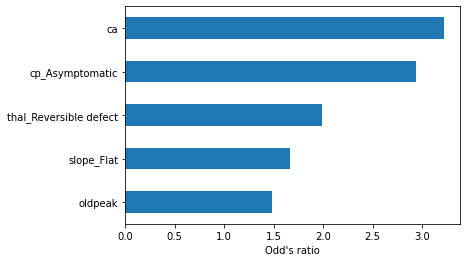

In [62]:
odd_ratio.tail(5).plot(kind = "barh")
plt.xlabel("Odd's ratio");

**Task 18:**  Create a horizontal bar chart with the five smallest coefficients from the series above

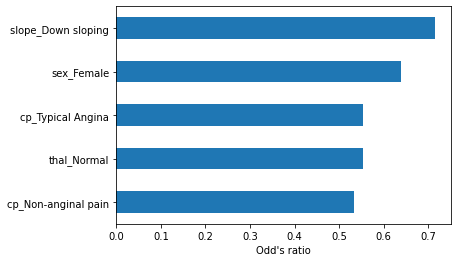

In [63]:
odd_ratio.head(5).plot(kind = "barh")
plt.xlabel("Odd's ratio");

# Conclusion

<font face = "calibri">
<p>
From the plots above, people that have Asymptomatic type of symptoms are most likely to suffer heart failures, than people that show symptoms of chest pain. This is because this category of people do not feel pains and as such may assume their heart is in perfect condition
<p> Hence, chest pain is not an indicator of a heart disease